<h1> Homework Set 6</h1>
Matt Buchovecky  
Astro 283 / Fitz 

In [1]:
import numpy as np
from scipy import optimize, special 
from matplotlib import pyplot as plt
from astropy.io import fits
%matplotlib inline

<h2> Problem 1

In [2]:
# open the data file and load data into a list of points 
infile = open("./samplevals_PA.txt", 'r')
v_arr = [ ]

for line in iter(infile):
    line = line.split()
    try:
        float(line[0])
        v_arr.append(float(line[0]))
    except ValueError:
        continue
    
infile.close()


(array([  8.,  11.,  10.,   7.,   8.,   4.,   1.,   0.,   0.,   1.]),
 array([  0.53738285,   2.30919936,   4.08101587,   5.85283239,
          7.6246489 ,   9.39646541,  11.16828193,  12.94009844,
         14.71191495,  16.48373146,  18.25554798]),
 <a list of 10 Patch objects>)

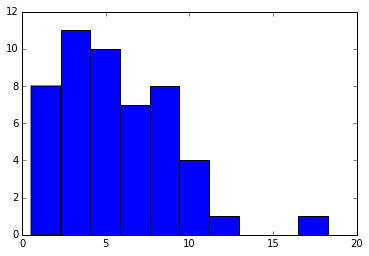

In [3]:
# get a first look at the distribution to make guesses 
plt.hist(v_arr)


To estimate the values of $(\alpha,\beta)$, we maximize the posterior function $p(\alpha,\beta\mid\{D\})$ with respect to $\alpha$ and $\beta$. From Baye's rule, and assuming the prior $p(\alpha,\beta)$ is uniform, this is equivalent to maximizing the likelihood function since

The first step is to find the values of $\alpha$ and $\beta$ that maximize the posterior function $p(\alpha,\beta\mid\{D_x\})$ - applying Baye's rule gives 

$$
p(\alpha,\beta\mid\{D\}) = \frac{p\left(\{D_x\}\mid\alpha,\beta\right)p\left(\alpha,\beta\right)}{p\left(\{D_x\}\right)}
$$

assuming uniform priors, we can simplify the dependence of the posterior on the parameters to be just the product of the likelihood functions for each x-value
$$
p(\alpha,\beta\mid\{D\}) \propto \prod_i p(x_i\mid\alpha,\beta)
$$

where the likelihood function in this case is just the Rice distribution 

$$
p(x_i\mid \alpha,\beta) = \left\{
\begin{array}{ll}
\alpha^{-1}\exp\left(-\frac{x_i+\beta}{\alpha}\right)I_0\left(\frac{2\sqrt{x_i\beta}}{\alpha}\right) & \quad x_i\geq 0\\
0 & \quad\text{otherwise}
\end{array}
\right.
$$

We can use a minimizer to minimize the opposite of the posterior, which is the same as maximizing it. Note we can apply this same logic for finding the parameters that maximize the parameter of a Poisson-like Gaussian, which is the mean and the variance. 

Below I define the functions, then run the minimizer..


In [4]:
# define the pdfs and likelihood functions

def Rice_dist(x, alpha, beta):
    """the pdf of the Rice distribution for a single value"""
    return (1/alpha)*np.exp((x+beta)/(-alpha))*special.iv(0, 2*np.sqrt(x*beta)/alpha)

def Rice_dist_n(x, alpha, beta):
    """the pdf of the Rice distribution for an array"""
    condlist = [ x>0 ]
    choicelist = [ Rice_dist(x, alpha, beta) ]
    return np.select(condlist, choicelist, default=0.0)
        
def Rice_dist_gen(x, alpha, beta):
    """pdf of Rice distribution that works for single values and array types"""
    print('hi')
    
def gaussian_1param(x, mu):
    """gaussian pdf with variance equal to the mean"""
    return np.exp(-(x-mu)**2/mu)/np.sqrt(2*np.pi*mu)

def neg_likelihood(params, value_array, function):
    """the opposite of the likelihood function for a set of independent values for a given \\
    function"""
    l = -1
    for x in value_array:
        l *= function(x, *params)
    return l


In [28]:
# perform the optimization on both functions
guess = (2, 3)
opt_rice = optimize.fmin(neg_likelihood, guess, args=(v_arr, Rice_dist))
print(opt_rice)

guess = (np.mean(v_arr),)
opt_gauss = optimize.fmin(neg_likelihood, guess, args=(v_arr, gaussian_1param))
print(opt_gauss)


Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 40
         Function evaluations: 75
[ 1.12949817  4.50316054]
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 15
         Function evaluations: 30
[ 6.33863274]


The optimal values for the Rice fitting are: 

\begin{eqnarray}
\alpha &\approx& 1.13\\
\beta &\approx& 4.50\\
\end{eqnarray}

and for the Gaussian:
$\mu \approx 6.33$

To visualize these results, I will plot these distributions with the optimal parameters against the histogram of the given data. 

I then plot the posterior function in parameter space to give the parameter density function



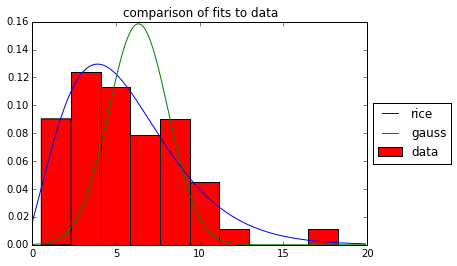

In [23]:
# plot the Rice distribution with optimal values against normed histogram
r = np.arange(0., 20., 0.1)
plt.plot(r, Rice_dist(r, *opt_rice), label='rice')
plt.plot(r, gaussian_1param(r, *opt_gauss), label='gauss')
plt.hist(v_arr, normed=True, label='data')
plt.legend(loc='center left', bbox_to_anchor=(1., 0.5))
plt.title("comparison of fits to data")


<h4> posterior density function for Rice distribution </h4>

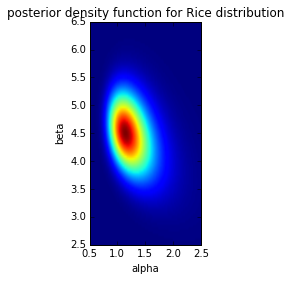

In [7]:
# define a mesh grid for parameter space plot 
alpha_range = np.linspace(0.5, 2.5, 100)
beta_range = np.linspace(2.5, 6.5, 100)
alpha_arr, beta_arr = np.meshgrid(alpha_range, beta_range)

# positive likelihood values for Rice distribution! 
Rice_arr = -neg_likelihood((alpha_arr, beta_arr), v_arr, Rice_dist_n)

# plot the posterior density function
ext = [alpha_range.min(), alpha_range.max(), beta_range.min(), beta_range.max()]
plt.imshow(Rice_arr, extent=ext, origin='lower')
plt.title("posterior density function for Rice distribution")
plt.xlabel('alpha')
plt.ylabel('beta')


To compare the distribution models to see which is a better fit, we compute the ratio of the probabilities of the models:

$$
\frac{P\left(R\mid\{D_x\}\right)}{P\left(G\mid\{D_x\}\right)} = \frac{\int p\left(R(\alpha,\beta)\mid\{D_x\}\right) d\alpha d\beta}{\int p\left(G(\mu)\mid\{D_x\}\right)d\mu}\\
$$

Expanding again using Baye's rule, and assuming the $P\left(\{D_x\}\right)$ terms will cancel on top and bottom, and the ratio becomes the ratio of the integrals of the likelihoods times the priors

$$
\frac{\int p\left(R(\alpha,\beta)\mid\{D_x\}\right) d\alpha d\beta}{\int p\left(G(\mu)\mid\{D_x\}\right)d\mu} = 
\frac{\int p\left(\{D_x\}\mid\alpha,\beta,R\right)p(\alpha,\beta) d\alpha d\beta}{\int p\left(\{D\}\mid\mu,G\right)p(\mu) d\mu}
$$

This integral can be difficult, so we make two assumptions. First, if we assume roughly constant priors over some range, then they can be pulled out of the integral, and give the ratio:

$$\frac{p(\alpha,\beta)}{p(\mu)} = \frac{\mu_{\text{max}}-\mu_{\text{min}}}{(\alpha_\text{max}-\alpha_\text{min})(\beta_\text{max}-\beta_\text{min})}$$

Next, we approximate that the likelihood functions are Gauss distributed around the optimal values  
\begin{eqnarray}
\int{p\left(\{D_x\}\mid R(\alpha,\beta)\right) d\alpha d\beta} &=& p\left(\{D_x\}\mid R(\alpha_0,\beta_0)\right)\int{g(\alpha,\beta)d\alpha d\beta} \\
&=& 2\pi\left|\Sigma_{\alpha,\beta}\right|p\left(\{D_x\}\mid R(\alpha_0,\beta_0)\right)
\end{eqnarray}
\begin{eqnarray}
\int{p\left(\{D_x\}\mid G(\mu)\right) d\mu} &=& p\left(\{D_x\}\mid G(\mu_0)\right)\int{g(\mu)d\mu} \\
&=& \sqrt{2\pi\sigma_{\mu}}p\left(\{D_x\}\mid G(\mu_0)\right)
\end{eqnarray}
and similarly for the Poisson-like Gaussian, but with only 1-dimension. The integral of the gaussian is just proportional to the errors on the parameters (determinant of the covariance matrix for the 2D Rice case)

There are multiple factors in this ratio now, let's take a look at the optimal posterior ratio first..


In [21]:
# find the ratio of likelihood functions 
ratio = neg_likelihood(opt_rice, v_arr, Rice_dist_n) / neg_likelihood(opt_gauss, v_arr, gaussian_1param)
print(ratio)

2.14157719612e+26



We can see the major factor after calculating is:

$$
\frac{p(\{D_x\}\mid R(\alpha,\beta))}{p(\{D_x\}\mid G(\mu_0)} \sim 2\cdot 10^{26}
$$

Putting everything together, the 

$$
\frac{P(R\mid\{D_x\})}{P(G\mid\{D_x\})} \approx \sqrt{2\pi}
\frac{p(\{D_x\}\mid R(\alpha_0,\beta_0))}{p(\{D_x\}\mid G(\mu_0))}
\frac{\det{\Sigma_{\alpha,\beta}}}{\sigma_{\mu}}
\frac{(\alpha_\text{max}-\alpha_\text{min})(\beta_\text{max}-\beta_\text{min})}{\mu_\text{max}-\mu_\text{min}}
$$



The other factors could be large, but will be nowhere near this magnitude

$$
\frac{P(R\mid\{D_x\})}{P(G\mid\{D_x\})} \gg 1
$$

Thus, the Rice distribution is a much better fit. We expect this result, as the numbers were indeed generated from a Rice distribution, and the Gaussian fit appeared visually to be extremely poor


<h2> Problem 2 </h2>

In [8]:
# read in the data and close files 
model_fits = fits.open("./data/hw6prob2_model.fits")
psf_fits = fits.open("hw6prob2_psf.fits")
print(model_fits.info())
print(psf_fits.info())

model_data = model_fits[0].data
psf_data = psf_fits[0].data

model_fits.close()
psf_fits.close()


Filename: hw6prob2_model.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       7   (128, 128, 128)   float64   
None
Filename: hw6prob2_psf.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       6   (64, 64)     float64   
None


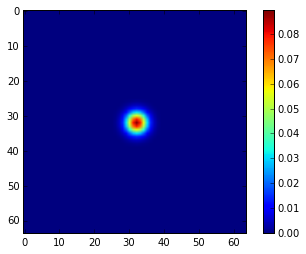

In [9]:
plt.imshow(psf_data)
cbar = plt.colorbar()
cbar.solids.set_edgecolors('face')

Integrating the model along the 0th (slow) dimension. For a discrete array, this amounts to summing across each value in the 0th dimension for each coordinate in the other two dimensions. In most cases there would be a multiplicative factor of the bin width to represent $\delta x$, but here we are doing it in units of pixels with value $1$

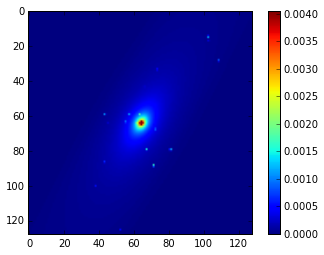

In [10]:
model_data_intgrl = np.sum(model_data, axis=0)
f = plt.figure()
plt.imshow(model_data_intgrl)
cbar = plt.colorbar()
cbar.solids.set_edgecolors('face')

In [11]:
# define FFT functions 

def cool_turkey_fft(arr, N=0, s=1, **kwargs): # inverse=False
    """performs a 1-dimensional fast Fourier transform
    on arr using the Cooley–Tukey algorithm. 
    return: transformed array, ndarray
    keyword arguments: inverse=False
                        performs inverse FFT"""
    if N == 0:
        N = len(arr)
    sign = 1 # sign that goes into exponential, + implies not doing inverse transform
    # iter(kwargs)
    for key, value in kwargs.items():
        if key == 'inverse' and value:
            sign = -1 
    s = int(s)
    ARR = np.zeros(N, dtype=complex)
    if N == 1:
        ARR[0] = arr[0]
    else:
        N2 = int(N/2)
        ARR[0:N2] = cool_turkey_fft(arr[0::2*s], N2, s, **kwargs)
        ARR[N2:] = cool_turkey_fft(arr[1::2*s], N2, s, **kwargs)
        for k in range(0, N2):
            orig = ARR[k]
            ARR[k] = orig + np.exp(-sign*2*np.pi*(1j)*k/N)*ARR[k+N2]
            ARR[k+N2] = orig - np.exp(-sign*2*np.pi*(1j)*k/N)*ARR[k+N2]
    return ARR

def ifft(arr, fft_method, *args, **kwargs): # =cool_turkey_fft
    """performs inverse of 1d fast Fourier transform"""
    kwargs['inverse'] = True
    ARR = fft_method(arr, *args, **kwargs)
    return ARR / len(ARR)
    
def fft_2d(arr_2d, fft_1d, *args, **kwargs): # =cool_turkey_fft
    """performs a fast Fourier transform in 2 dimensions"""
    # check type of array
    # check dimensions
    nx, ny = arr_2d.shape
    N = nx
    
    ARR_2d = np.zeros((N,N), dtype=np.complex64)
    
    for i in range(0, N):
        ARR_2d[i,:] = fft_1d(arr_2d[i,:], *args, **kwargs)
        
    for j in range(0, N):
        ARR_2d[:,j] = fft_1d(ARR_2d[:,j], *args, **kwargs)
        
    return ARR_2d
        
def zero_pad_symm2d(arr, shape):
    """pads array with 0s, placing original values in the center symmetrically
        returns ndarray of given shape"""
    # check new shape big enough to include old shape 
    sh0 = arr.shape
    ARR = np.zeros(shape)
    
    ARR[int((shape[0]-sh0[0])/2):int((shape[0]+sh0[0])/2), int((shape[1]-sh0[1])/2):int((shape[1]+sh0[1])/2)] = arr
    
    return ARR


<h3> Performing the convolution </h3>
The convulution will just be the product 
First the data arrays are padded with zeros, large enough to include the whole PSF at the edge of the model array  
Then, both arrays are transformed into Fourier space using our defined FFT in 2-dimensions.  
In this space, the convolution is just the element-wise product of each array 
The inverse FFT must be applied to view it in real space  
The result is shifted for some reason, part of the transormation process. We use a numpy function to shift it back 

In [12]:
# do the padding 
size_full = model_data_intgrl.shape[0] + 2*psf_data.shape[0]
psf_data_padded = zero_pad_symm2d(psf_data, (size_full,size_full))
model_data_padded = zero_pad_symm2d(model_data_intgrl, (size_full,size_full))

# FFT the 2D data 
psf_fft = fft_2d(psf_data_padded, cool_turkey_fft)
model_fft = fft_2d(model_data_padded, cool_turkey_fft)



In [13]:
# convolve model with PSF
convoluted_data_fft = psf_fft * model_fft

# inverse FFT to get back to real space
convoluted_data_space = fft_2d(convoluted_data_fft, cool_turkey_fft, inverse=True)

# shift back 
convoluted_data_space = np.fft.fftshift(convoluted_data_space)


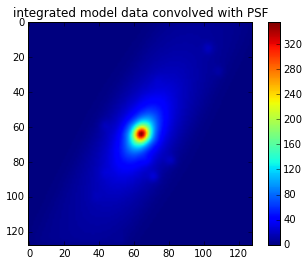

In [14]:
# plot the result, looks good!
f = plt.figure()
plt.imshow(np.real(convoluted_data_space[64:192, 64:192]))
plt.title("integrated model data convolved with PSF")
cbar = plt.colorbar()
cbar.solids.set_edgecolors('face')

The result looks good, we can see the small points become wider blurs, but the overall picture looks the same!

In [29]:
import pandas
pandas.